<a href="https://colab.research.google.com/github/RoxieCardonax/LeafIdentification/blob/main/VGG16_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0. Install Dependencies and Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip install scikit-learn

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.1
arviz                            0.15.1
astropy                          5.3.3
astunparse                       1.6.3
async-timeout                    4.0.3
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0
blinker                          1.4
bl

In [ ]:
!pip install keras

In [ ]:
import tensorflow as tf
import os

In [ ]:
#Only use 50% of GPU
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Oct  2 22:32:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    40W / 300W |    566MiB / 16384MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1.1. Remove Dodgy Image

In [ ]:
import cv2
import imghdr # allows to check file extensions
from matplotlib import pyplot as plt

In [ ]:
data_dir = '/content/drive/MyDrive/leafhealth/resize_data' #variable to hold path to data directory

In [ ]:
image_extensions = ['jpeg','jpg', 'bmp', 'png'] #list of standard image file extensions

In [ ]:
# for loop - looping through directory and then every image to check if they can be used by cv2 and imghdr if not then they are removed
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path) #not a valid image
            tip = imghdr.what(image_path) #not a valid image extension
            if tip not in image_extensions:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [ ]:
#How many classes are there?
num_classes = 0

#Iterate Directory
for path in os.listdir(data_dir):
    num_classes += 1
print ('File count:', num_classes)


File count: 2


# 2.0. Load Data

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
#Build the data pipeline
data = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/leafhealth/data',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 4502 files belonging to 2 classes.


In [ ]:
len(data)

141

In [ ]:
data_iterator = data.as_numpy_iterator() #access the generator from data pipeline - allowing us to loop through data pipeline

In [ ]:
batch = data_iterator.next() #accessing the data piepline itself

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


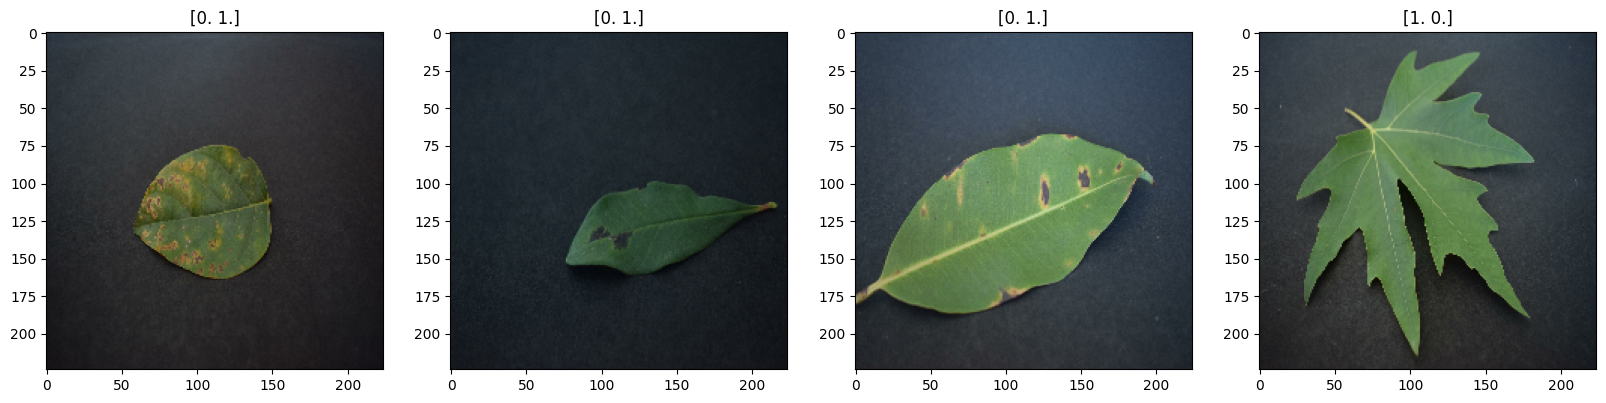

In [ ]:
# for loop - looping through the images and classifying them as healthy = 0 and unhealthy = 1
#shows the classifications 0=healthy, 1 = unhealthy
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 3.0. Pre-Processing Data

## 3.1. Scale Data

In [ ]:
data = data.map(lambda x,y: (x/255, y)) #map - applies a particular transformation as data is being preprocessed by the data pipeline... x = images, y = target values

In [ ]:
scaled_iterator=data.as_numpy_iterator()

In [ ]:
batch = scaled_iterator.next()

In [ ]:
#CHECK FOR BATCH MAX AND MIN 0 - 1
#batch [0].min()
batch [0].max()

0.96624446

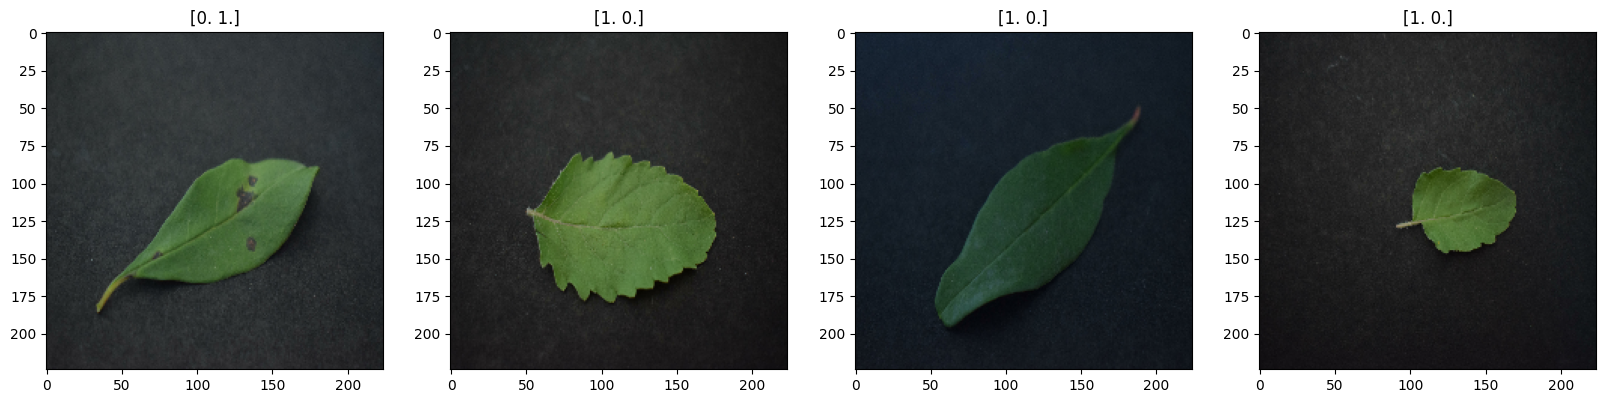

In [ ]:
#CHECK IF IMAGES ARE LOADED AND SCALED
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])
    #shows the classifications unhealthy = 1 and healthy = 0

## 3.2. Split Data

In [ ]:
#Partitian Allocation
train_size = np.array((len(data)*.7)) #training will be 70% of data
val_size = np.array((len(data)*.2)) #20% for validation
test_size = np.array((len(data)*.1+1)) #10% testing + 1 because the data is an uneven number

In [ ]:
#CHECK that it is equal to length
train_size+val_size+test_size

142.0

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
len(test)

15

# 4.0. Deep Learning Model

## 4.1. Load VGG16 Model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467096/553467096 [==============================] - 7s 0us/step


In [ ]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
#Output layer
model.add(Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='sigmoid'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
# compile model
model.compile(optimizer=SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

## 4.2. Train

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=100, validation_data=val) #fit is the training function

Epoch 1/100
98/98 [==============================] - 989s 10s/step - loss: 4.7812 - accuracy: 0.5057 - val_loss: 6.0011 - val_accuracy: 0.5179
Epoch 2/100
98/98 [==============================] - 757s 8s/step - loss: 4.2106 - accuracy: 0.5424 - val_loss: 0.6677 - val_accuracy: 0.6886
Epoch 3/100
98/98 [==============================] - 772s 8s/step - loss: 4.2326 - accuracy: 0.5265 - val_loss: 2.4216 - val_accuracy: 0.5045
Epoch 4/100
98/98 [==============================] - 743s 7s/step - loss: 4.0801 - accuracy: 0.5290 - val_loss: 3.1119 - val_accuracy: 0.4944
Epoch 5/100
98/98 [==============================] - 772s 8s/step - loss: 3.5653 - accuracy: 0.5529 - val_loss: 0.8929 - val_accuracy: 0.7221
Epoch 6/100
98/98 [==============================] - 772s 8s/step - loss: 3.3279 - accuracy: 0.5708 - val_loss: 3.2913 - val_accuracy: 0.5167
Epoch 7/100
98/98 [==============================] - 759s 8s/step - loss: 3.5622 - accuracy: 0.5558 - val_loss: 1.9059 - val_accuracy: 0.6116
Epoch

## 4.3. Plot Performance

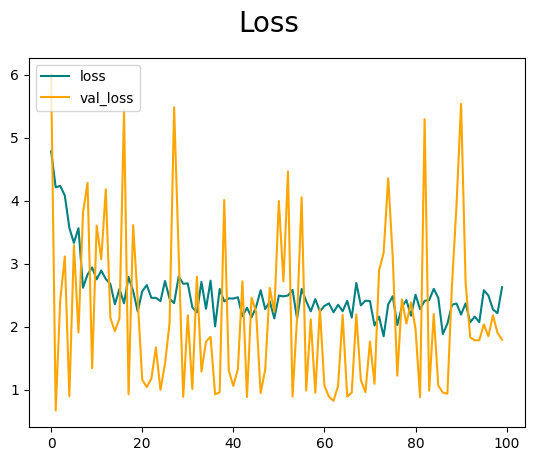

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

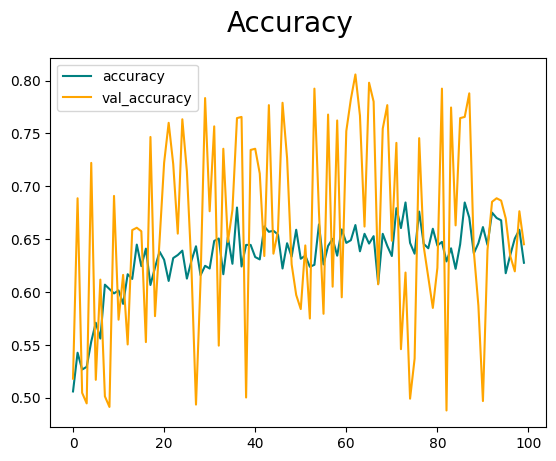

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 5.0 Evaluate

In [1]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [2]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [3]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

NameError: ignored

In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy: {acc.result().numpy()}')

## 5.1 Predications

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
test_labels = y

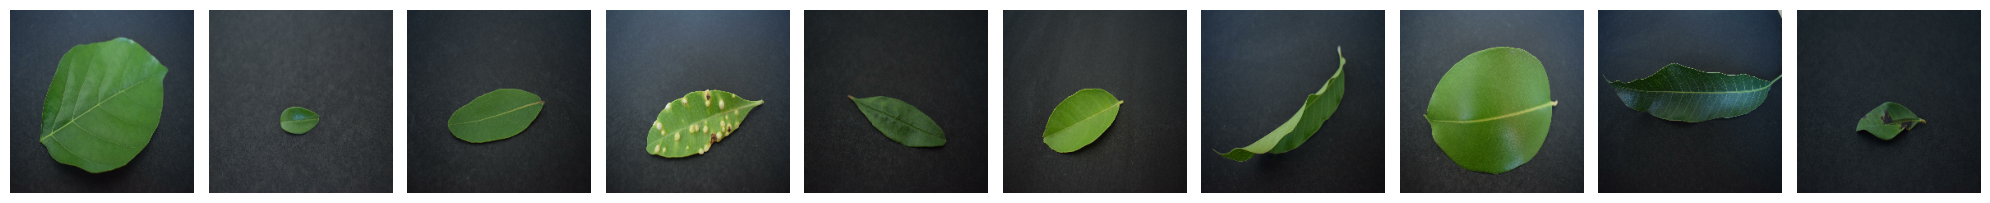

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [ ]:
plotImages(X)
print(test_labels)

In [ ]:
predictions = yhat

In [ ]:
flatten_pred = predictions.flatten()

In [ ]:
# Convert to 0 and 1
round_pred=[]

for x in flatten_pred:
    if x < 0:
        x=0
    else:
        x=1
    round_pred.append(x)

In [ ]:
round_pred=np.array(round_pred)

In [ ]:
round_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
test_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## 5.2 Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=round_pred)

ValueError: ignored

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['healthy','unhealthy']

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# 6.0 Test

In [ ]:
import cv2
from matplotlib import pyplot as plt

In [ ]:
img = cv2.imread('healthy_test.jpg')
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5:
    print(f'Predicted class is Unhealthy')
else:
    print(f'Predicted class is Healthy')

# 7.0 Save Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','leafhealth.h5'))

In [ ]:
new_model = load_model('models/leafhealth.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

In [ ]:
#Verify that laoded model has the same achitecture and weights as the saved model
new_model.summary()

# 8.0 Augmentation

NEED TO ADJUST SO THAT WHEN RUN THROUGH ONCE IT AUGMENTS ALL THE DATA

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [ ]:
chosen_image = random.choice(os.listdir('data/healthy'))

In [ ]:
image_path = 'data/healthy/' + chosen_image

In [ ]:
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [ ]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True)

In [ ]:
aug_iter = gen.flow(image)
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

In [ ]:
plotImages(aug_images)

In [ ]:
aug_iter = gen.flow(image, save_to_dir='data/healthy', save_prefix='aug-image-', save_format='jpeg')